## Kyaw Htet Paing Win

**Motivation & Goal:**

Since Rangpur is a major city in Bangladesh that is known to be affected by flood, the goal of this notebook is to forecast the average rainfall in the city based on the weather pattern.

**Model & Results:**

The XGBoost model after hyper-parameter tuning shows promising results. Some key metrics of the model on test data are as follow:

1. RMSE: 5.2992 mm per day
2. MAE: 2.8471 mm per day (Better metric)
3. R2: 72.98%

**Key Finding:**

The amount of rainfall from the previous day (i.e. the newly devised feature called precip_mean_1) is the strongest predictor of the next day rainfall.

**Conclusion:**

Given the distribution of precipitation with daily average precipitation of 6.66 mm and a standard deviation of 12.80 mm, these metrics indicates a model with reasonable predictive power.

**Future Work Suggestions:**

1. Since there are extreme precipitation on certain days, incorporate additional data sources to improve model robustness.

2. Further improve the feature engineering process to capture complex rainfall pattern.





**Meta data:**

---

* Year: Year

* DOY: Day of the Year

* T2M: Temperature at 2 Meters (C) - Average air temperature at 2 meters above the ground.

* T2M_RANGE: Temperature at 2 Meters Range (C) - Range of minimum and maximum hourly air temperature at 2 meters.

* T2M_MAX: Temperature at 2 Meters Maximum (C) - Maximum hourly air temperature at 2 meters.

* T2M_MIN: Temperature at 2 Meters Minimum (C) - Minimum hourly air temperature at 2 meters.

* QV2M: Specific Humidity at 2 Meters (g/kg) - Mass of water vapor per unit mass of air at 2 meters.

* RH2M: Relative Humidity at 2 Meters (%) - Relative humidity of the air at 2 meters.

* PRECTOTCORR: Precipitation Corrected (mm/day) - Bias-corrected total precipitation per day.

* WS2M: Wind Speed at 2 Meters (m/s) - Average wind speed at 2 meters above the ground.

* WS2M_MAX: Wind Speed at 2 Meters Maximum (m/s) - Maximum hourly wind speed at 2 meters.

* WS2M_MIN: Wind Speed at 2 Meters Minimum (m/s) - Minimum hourly wind speed at 2 meters.

* WS2M_RANGE: Wind Speed at 2 Meters Range (m/s) - Range of minimum and maximum hourly wind speed at 2 meters.

* WD2M: Wind Direction at 2 Meters (Degrees) - Average wind direction at 2 meters above the ground.

* PS: Surface Pressure (kPa) - Average surface atmospheric pressure.

* GWETTOP: Surface Soil Wetness - Percent of soil moisture, 0 indicating dry and 100 indicating saturation.

* GWETROOT: Root Zone Soil Wetness - Percent of root zone soil wetness, 0 indicating dry and 100 indicating saturation.

* GWETPROF: Profile Soil Moisture - Percent of profile soil moisture, 0 indicating dry and 100 indicating saturation.

* Latitude: Latitude - Geographic coordinate that specifies the north–south position.

* Longitude: Longitude - Geographic coordinate that specifies the east-west position.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [98]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


In [3]:
file_path = '/content/drive/MyDrive/GIS Data Analysis/Rangpur_data.csv'

In [4]:
df = pd.read_csv(file_path)

In [5]:
df.head()

,YEAR,DOY,T2M,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,WS2M,PS,WS2M_MAX,WS2M_MIN,GWETTOP,WS2M_RANGE,WD2M,GWETROOT,GWETPROF,latitude,longitude
0,2015,174,29.39,5.83,32.75,26.92,22.58,87.25,26.21,2.80,99.19,4.19,1.46,0.84,2.73,121.50,0.76,0.71,25.942367,89.445929
1,2015,175,28.41,2.86,29.84,26.98,23.13,93.75,33.15,2.88,99.10,4.86,1.05,0.86,3.81,73.19,0.78,0.73,25.942367,89.445929
2,2015,176,28.83,4.23,31.33,27.12,22.64,89.88,15.45,1.30,98.99,2.21,0.80,0.85,1.41,171.81,0.81,0.76,25.942367,89.445929
3,2015,177,28.73,4.93,31.23,26.30,22.52,89.62,27.85,1.39,98.82,2.23,0.80,0.87,1.43,252.31,0.83,0.77,25.942367,89.445929
4,2015,178,28.96,6.02,32.48,26.47,22.40,88.50,19.86,4.05,99.14,4.95,2.18,0.88,2.77,117.12,0.84,0.79,25.942367,89.445929


In [7]:
# 65 Unique geogrpahic location within the Rangpur
df[['latitude', 'longitude']].drop_duplicates()

,latitude,longitude
0,25.942367,89.445929
132,25.474942,89.122640
264,25.912099,89.676357
396,25.589834,88.798265
528,25.476021,89.547919
...,...,...
181386,25.989078,89.085972
184463,26.129044,88.436942
189898,25.741417,89.032871
193851,25.964903,88.514485


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200005 entries, 0 to 200004
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   YEAR         200005 non-null  int64  
 1   DOY          200005 non-null  int64  
 2   T2M          200005 non-null  float64
 3   T2M_RANGE    200005 non-null  float64
 4   T2M_MAX      200005 non-null  float64
 5   T2M_MIN      200005 non-null  float64
 6   QV2M         200005 non-null  float64
 7   RH2M         200005 non-null  float64
 8   PRECTOTCORR  200005 non-null  float64
 9   WS2M         200005 non-null  float64
 10  PS           200005 non-null  float64
 11  WS2M_MAX     200005 non-null  float64
 12  WS2M_MIN     200005 non-null  float64
 13  GWETTOP      200005 non-null  float64
 14  WS2M_RANGE   200005 non-null  float64
 15  WD2M         200005 non-null  float64
 16  GWETROOT     200005 non-null  float64
 17  GWETPROF     200005 non-null  float64
 18  latitude     200005 non-

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
YEAR,200005.0,2019.176146,2.449000,2015.000000,2017.000000,2019.000000,2021.000000,2023.000000
DOY,200005.0,186.544361,104.300385,1.000000,97.000000,191.000000,276.000000,366.000000
T2M,200005.0,24.591168,26.542311,-999.000000,21.630000,27.350000,28.830000,35.790000
T2M_RANGE,200005.0,8.765459,26.019269,-999.000000,5.970000,8.950000,12.690000,21.350000
T2M_MAX,200005.0,29.655406,26.568448,-999.000000,27.600000,30.850000,32.790000,44.960000
T2M_MIN,200005.0,20.240649,26.629685,-999.000000,16.170000,22.940000,25.980000,30.070000
QV2M,200005.0,14.612189,26.521058,-999.000000,9.580000,15.810000,21.180000,24.540000
RH2M,200005.0,72.878541,32.204961,-999.000000,63.190000,79.810000,86.620000,96.880000
PRECTOTCORR,200005.0,6.035852,28.643619,-999.000000,0.000000,0.840000,8.080000,213.300000
WS2M,200005.0,1.051089,25.515516,-999.000000,1.160000,1.550000,2.110000,8.040000


In [10]:
# -999 are all errors
err_condition = (df == -999).any(axis=1)
err_condition

0         False
1         False
2         False
3         False
4         False
          ...  
200000     True
200001     True
200002     True
200003     True
200004     True
Length: 200005, dtype: bool

In [15]:
err_df = df[err_condition].groupby(['YEAR', 'DOY']).count()
err_df

T2M  T2M_RANGE  T2M_MAX  T2M_MIN  QV2M  RH2M  PRECTOTCORR  WS2M  PS  \
YEAR DOY                                                                        
2023 183   65         65       65       65    65    65           65    65  65   
     184   65         65       65       65    65    65           65    65  65   
     185   65         65       65       65    65    65           65    65  65   
     186   65         65       65       65    65    65           65    65  65   
     187   65         65       65       65    65    65           65    65  65   
...       ...        ...      ...      ...   ...   ...          ...   ...  ..   
     324   65         65       65       65    65    65           65    65  65   
     325   65         65       65       65    65    65           65    65  65   
     326   65         65       65       65    65    65           65    65  65   
     327   65         65       65       65    65    65           65    65  65   
     328   65         65       65       65    65    65           65    65  65   

          WS2M_MAX  WS2M_MIN  GWETTOP  WS2M_RANGE  WD2M  GWETROOT  GWETPROF  \
YEAR DOY                                                                      
2023 183        65        65       65          65    65        65        65   
     184        65        65       65          65    65        65        65   
     185        65        65       65          65    65        65        65   
     186        65        65       65          65    65        65        65   
     187        65        65       65          65    65        65        65   
...            ...       ...      ...         ...   ...       ...       ...   
     324        65        65       65          65    65        65        65   
     325        65        65       65          65    65        65        65   
     326        65        65       65          65    65        65        65   
     327        65        65       65          65    65        65        65   
     328        65        65       65          65    65        65        65   

          latitude  longitude  
YEAR DOY                       
2023 183        65         65  
     184        65         65  
     185        65         65  
     186        65         65  
     187        65         65  
...            ...        ...  
     324        65         65  
     325        65         65  
     326        65         65  
     327        65         65  
     328        65         65  

[146 rows x 18 columns]

In [16]:
err_df.index

MultiIndex([(2023, 183),
            (2023, 184),
            (2023, 185),
            (2023, 186),
            (2023, 187),
            (2023, 188),
            (2023, 189),
            (2023, 190),
            (2023, 191),
            (2023, 192),
            ...
            (2023, 319),
            (2023, 320),
            (2023, 321),
            (2023, 322),
            (2023, 323),
            (2023, 324),
            (2023, 325),
            (2023, 326),
            (2023, 327),
            (2023, 328)],
           names=['YEAR', 'DOY'], length=146)

In [18]:
# Check if days are in 183 to 328
days = err_df.index.get_level_values('DOY')
is_in_range = (days >= 183) & (days <= 328)
print(is_in_range.all())

True


**Fixing the erroneous error column:**

Since most of the weather related features are missing from July to December
of 2023 for all 65 geographic lcoations, let's drop these rows altogether.

In [19]:
df.shape

(200005, 20)

In [20]:
weather_err_condition = (df['YEAR'] == 2023) & (df['DOY'] >= 183) & (df['DOY'] <= 328)
weather_err_condition

0         False
1         False
2         False
3         False
4         False
          ...  
200000     True
200001     True
200002     True
200003     True
200004     True
Length: 200005, dtype: bool

In [21]:
# Drop columns from df that meets weather_err_condition
df.drop(df[weather_err_condition].index, inplace=True)

In [22]:
df.shape

(190515, 20)

In [23]:
df.tail()

,YEAR,DOY,T2M,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,WS2M,PS,WS2M_MAX,WS2M_MIN,GWETTOP,WS2M_RANGE,WD2M,GWETROOT,GWETPROF,latitude,longitude
199854,2023,178,28.34,5.84,31.65,25.81,21.42,88.38,14.18,3.31,99.68,4.82,2.05,0.81,2.77,112.69,0.80,0.76,25.894761,88.810787
199855,2023,179,27.88,5.07,30.75,25.68,21.36,90.31,24.09,2.83,99.86,4.47,1.42,0.84,3.05,118.69,0.82,0.77,25.894761,88.810787
199856,2023,180,27.94,4.58,30.49,25.90,21.42,90.31,37.92,2.53,99.81,3.68,1.75,0.87,1.92,154.38,0.84,0.80,25.894761,88.810787
199857,2023,181,27.82,4.66,30.40,25.74,21.73,91.88,29.99,2.11,99.66,3.53,0.82,0.89,2.71,187.88,0.88,0.84,25.894761,88.810787
199858,2023,182,28.94,6.45,32.27,25.83,21.85,87.06,36.16,2.05,99.69,3.45,0.88,0.90,2.57,193.75,0.90,0.85,25.894761,88.810787


In [24]:
df.head()

,YEAR,DOY,T2M,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,WS2M,PS,WS2M_MAX,WS2M_MIN,GWETTOP,WS2M_RANGE,WD2M,GWETROOT,GWETPROF,latitude,longitude
0,2015,174,29.39,5.83,32.75,26.92,22.58,87.25,26.21,2.80,99.19,4.19,1.46,0.84,2.73,121.50,0.76,0.71,25.942367,89.445929
1,2015,175,28.41,2.86,29.84,26.98,23.13,93.75,33.15,2.88,99.10,4.86,1.05,0.86,3.81,73.19,0.78,0.73,25.942367,89.445929
2,2015,176,28.83,4.23,31.33,27.12,22.64,89.88,15.45,1.30,98.99,2.21,0.80,0.85,1.41,171.81,0.81,0.76,25.942367,89.445929
3,2015,177,28.73,4.93,31.23,26.30,22.52,89.62,27.85,1.39,98.82,2.23,0.80,0.87,1.43,252.31,0.83,0.77,25.942367,89.445929
4,2015,178,28.96,6.02,32.48,26.47,22.40,88.50,19.86,4.05,99.14,4.95,2.18,0.88,2.77,117.12,0.84,0.79,25.942367,89.445929


In [25]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
YEAR,190515.0,2018.985670,2.351962,2015.000000,2017.000000,2019.000000,2021.000000,2023.000000
DOY,190515.0,183.109519,105.277392,1.000000,92.000000,183.000000,274.000000,366.000000
T2M,190515.0,25.133328,4.844898,11.280000,21.300000,27.300000,28.780000,35.790000
T2M_RANGE,190515.0,9.540874,4.095483,1.200000,5.980000,9.150000,12.880000,21.350000
T2M_MAX,190515.0,30.262873,4.261824,16.680000,27.400000,30.810000,32.730000,44.960000
T2M_MIN,190515.0,20.722023,5.822583,4.020000,15.860000,22.640000,25.910000,30.070000
QV2M,190515.0,15.070996,5.961044,2.320000,9.340000,15.440000,21.120000,24.540000
RH2M,190515.0,73.147455,17.287119,8.880000,61.940000,79.500000,86.690000,96.880000
PRECTOTCORR,190515.0,6.663869,12.801682,0.000000,0.000000,0.720000,8.090000,213.300000
WS2M,190515.0,1.700755,0.749094,0.320000,1.160000,1.550000,2.100000,8.040000


In [27]:
# Filter rows where PRECTOTCORR value is max
precp_outlier = df[df['PRECTOTCORR'] == df['PRECTOTCORR'].max()]
precp_outlier

,YEAR,DOY,T2M,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,WS2M,PS,WS2M_MAX,WS2M_MIN,GWETTOP,WS2M_RANGE,WD2M,GWETROOT,GWETPROF,latitude,longitude
46318,2017,224,27.58,2.23,28.76,26.53,22.46,96.0,213.3,2.19,99.39,4.04,0.85,1.0,3.19,152.81,1.0,0.98,26.043463,89.053454
64252,2017,224,27.58,2.23,28.76,26.53,22.46,96.0,213.3,2.19,99.39,4.04,0.85,1.0,3.19,152.81,1.0,0.98,25.980880,88.814683
84361,2017,224,27.58,2.23,28.76,26.53,22.46,96.0,213.3,2.19,99.39,4.04,0.85,1.0,3.19,152.81,1.0,0.98,25.845412,88.443878
100121,2017,224,27.58,2.23,28.76,26.53,22.46,96.0,213.3,2.19,99.39,4.04,0.85,1.0,3.19,152.81,1.0,0.98,25.799605,88.856369
102457,2017,224,27.58,2.23,28.76,26.53,22.46,96.0,213.3,2.19,99.39,4.04,0.85,1.0,3.19,152.81,1.0,0.98,25.868758,88.861375
110947,2017,224,27.58,2.23,28.76,26.53,22.46,96.0,213.3,2.19,99.39,4.04,0.85,1.0,3.19,152.81,1.0,0.98,26.078616,88.585370
114024,2017,224,27.58,2.23,28.76,26.53,22.46,96.0,213.3,2.19,99.39,4.04,0.85,1.0,3.19,152.81,1.0,0.98,25.775633,89.052051
117101,2017,224,27.58,2.23,28.76,26.53,22.46,96.0,213.3,2.19,99.39,4.04,0.85,1.0,3.19,152.81,1.0,0.98,25.825422,88.481123
120178,2017,224,27.58,2.23,28.76,26.53,22.46,96.0,213.3,2.19,99.39,4.04,0.85,1.0,3.19,152.81,1.0,0.98,26.091750,89.032331
148725,2017,224,27.58,2.23,28.76,26.53,22.46,96.0,213.3,2.19,99.39,4.04,0.85,1.0,3.19,152.81,1.0,0.98,25.804645,88.692372


In [28]:
# Filter rows where YEAR = 2017 and DOY is 224 and PRECTOTCORR value is less than its max value
precp_others = df[(df['YEAR'] == 2017) & (df['DOY'] == 224) & (df['PRECTOTCORR'] < df['PRECTOTCORR'].max())]
precp_others

,YEAR,DOY,T2M,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,WS2M,PS,WS2M_MAX,WS2M_MIN,GWETTOP,WS2M_RANGE,WD2M,GWETROOT,GWETPROF,latitude,longitude
3295,2017,224,27.69,2.72,29.26,26.54,22.34,94.88,166.11,2.31,99.60,3.31,1.00,0.99,2.31,125.88,1.00,0.97,25.942367,89.445929
4355,2017,224,27.80,2.10,28.79,26.68,22.58,95.38,162.69,2.66,99.61,4.17,0.76,0.99,3.41,192.50,1.00,0.98,25.589834,88.798265
5150,2017,224,28.05,3.14,29.94,26.80,22.40,93.50,135.00,2.52,99.70,5.48,0.26,0.99,5.22,159.38,1.00,0.98,25.476021,89.547919
5680,2017,224,27.69,2.72,29.26,26.54,22.34,94.88,166.11,2.31,99.60,3.31,1.00,0.99,2.31,125.88,1.00,0.97,25.912099,89.676357
6210,2017,224,28.05,3.14,29.94,26.80,22.40,93.50,135.00,2.52,99.70,5.48,0.26,0.99,5.22,159.38,1.00,0.98,25.534277,89.293310
6740,2017,224,27.08,3.05,28.77,25.72,21.79,95.06,167.06,2.12,98.49,3.73,0.72,0.99,3.02,130.06,0.99,0.96,26.357809,88.579824
7270,2017,224,27.80,2.10,28.79,26.68,22.58,95.38,162.69,2.66,99.61,4.17,0.76,0.99,3.41,192.50,1.00,0.98,25.541828,88.671235
17774,2017,224,27.63,2.77,28.97,26.20,22.40,95.25,168.69,2.43,99.38,4.12,0.87,0.98,3.25,161.31,0.98,0.92,25.953475,88.349098
18099,2017,224,28.01,2.64,29.63,26.99,22.34,93.62,83.96,3.17,99.86,5.32,0.85,0.99,4.47,213.62,1.00,0.99,25.200719,89.520110
22018,2017,224,28.05,3.14,29.94,26.80,22.40,93.50,135.00,2.52,99.70,5.48,0.26,0.99,5.22,159.38,1.00,0.98,25.695413,89.175462


from matplotlib import pyplot as plt
precp_others['T2M'].plot(kind='hist', bins=20, title='T2M')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precp_others['T2M_RANGE'].plot(kind='hist', bins=20, title='T2M_RANGE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precp_others['T2M_MAX'].plot(kind='hist', bins=20, title='T2M_MAX')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precp_others['T2M_MIN'].plot(kind='hist', bins=20, title='T2M_MIN')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precp_others.plot(kind='scatter', x='T2M', y='T2M_RANGE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precp_others.plot(kind='scatter', x='T2M_RANGE', y='T2M_MAX', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precp_others.plot(kind='scatter', x='T2M_MAX', y='T2M_MIN', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precp_others.plot(kind='scatter', x='T2M_MIN', y='QV2M', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['YEAR']
  ys = series['T2M']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = precp_others.sort_values('YEAR', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('YEAR')
_ = plt.ylabel('T2M')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['YEAR']
  ys = series['T2M_RANGE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = precp_others.sort_values('YEAR', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('YEAR')
_ = plt.ylabel('T2M_RANGE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['YEAR']
  ys = series['T2M_MAX']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = precp_others.sort_values('YEAR', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('YEAR')
_ = plt.ylabel('T2M_MAX')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['YEAR']
  ys = series['T2M_MIN']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = precp_others.sort_values('YEAR', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('YEAR')
_ = plt.ylabel('T2M_MIN')

from matplotlib import pyplot as plt
precp_others['T2M'].plot(kind='line', figsize=(8, 4), title='T2M')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
precp_others['T2M_RANGE'].plot(kind='line', figsize=(8, 4), title='T2M_RANGE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
precp_others['T2M_MAX'].plot(kind='line', figsize=(8, 4), title='T2M_MAX')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
precp_others['T2M_MIN'].plot(kind='line', figsize=(8, 4), title='T2M_MIN')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: xlabel='latitude', ylabel='longitude'>

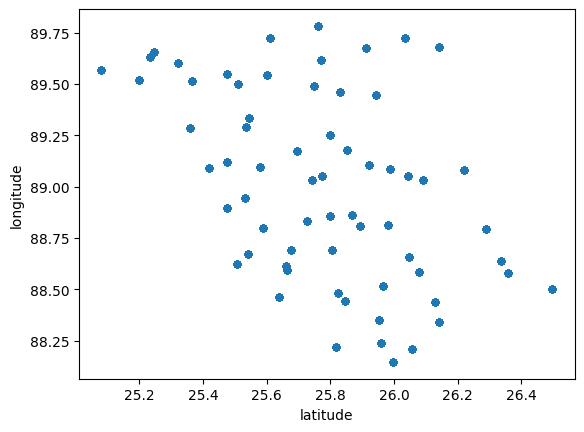

In [29]:
df[['latitude', 'longitude']].plot(kind='scatter', x='latitude', y='longitude')

In [30]:
# Average the weather features for each day
df_avg = df.groupby(['YEAR', 'DOY']).mean()
df_avg

T2M  T2M_RANGE    T2M_MAX    T2M_MIN       QV2M       RH2M  \
YEAR DOY                                                                     
2015 174  29.371538   6.204769  32.838615  26.636462  22.295538  86.274769   
     175  28.507231   3.308923  30.270462  26.956000  22.677692  91.460462   
     176  28.630154   4.278308  31.019538  26.743231  21.920000  87.993538   
     177  29.023846   4.961692  31.537385  26.577846  22.288615  87.341231   
     178  28.553385   5.633077  31.924769  26.295077  22.040615  89.034154   
...             ...        ...        ...        ...        ...        ...   
2023 178  28.389846   5.505077  31.424923  25.923385  21.339231  87.864462   
     179  28.103231   5.328769  31.127692  25.797692  21.290308  89.006769   
     180  27.964154   4.238308  30.336462  26.090615  21.471231  90.374000   
     181  28.100462   4.854154  30.858000  26.004615  21.878615  91.184000   
     182  29.028308   6.041846  32.215538  26.172923  21.913846  86.960923   

          PRECTOTCORR      WS2M         PS  WS2M_MAX  WS2M_MIN   GWETTOP  \
YEAR DOY                                                                   
2015 174    22.624000  3.153385  99.043077  4.484462  1.659385  0.767385   
     175    29.216615  2.603692  98.952923  3.912308  1.262923  0.798923   
     176    14.642154  1.822923  98.901846  3.022923  0.940154  0.788308   
     177    28.647077  1.705077  98.714923  2.610615  0.945846  0.820308   
     178    21.277538  3.887385  98.985692  5.361385  1.855077  0.834769   
...               ...       ...        ...       ...       ...       ...   
2023 178    15.409231  3.344615  99.733692  4.727385  2.134769  0.800000   
     179    21.554923  2.926769  99.906462  4.266923  1.751692  0.828615   
     180    32.101077  2.673538  99.865692  3.858154  1.727077  0.855538   
     181    22.626923  2.331692  99.716154  3.755846  1.147846  0.862462   
     182    40.693231  2.267538  99.749077  3.634923  1.127846  0.888615   

          WS2M_RANGE        WD2M  GWETROOT  GWETPROF   latitude  longitude  
YEAR DOY                                                                    
2015 174    2.822154  112.371231  0.699077  0.665231  25.776879  89.004148  
     175    2.649846  109.552154  0.724154  0.682615  25.776879  89.004148  
     176    2.081692  230.070769  0.748308  0.708615  25.776879  89.004148  
     177    1.664308  262.886000  0.773692  0.727077  25.776879  89.004148  
     178    3.505538  127.596462  0.796615  0.751846  25.776879  89.004148  
...              ...         ...       ...       ...        ...        ...  
2023 178    2.590308  120.806000  0.782308  0.745538  25.776879  89.004148  
     179    2.517077  130.249692  0.803538  0.761231  25.776879  89.004148  
     180    2.127538  162.446000  0.824462  0.782308  25.776879  89.004148  
     181    2.609846  188.023077  0.854923  0.810462  25.776879  89.004148  
     182    2.504154  193.046308  0.876923  0.829385  25.776879  89.004148  

[2931 rows x 18 columns]

In [31]:
# Set the index 'YEAR' and 'DOY' as column
df_avg.reset_index(inplace=True)

In [32]:
df_avg

,YEAR,DOY,T2M,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,WS2M,PS,WS2M_MAX,WS2M_MIN,GWETTOP,WS2M_RANGE,WD2M,GWETROOT,GWETPROF,latitude,longitude
0,2015,174,29.371538,6.204769,32.838615,26.636462,22.295538,86.274769,22.624000,3.153385,99.043077,4.484462,1.659385,0.767385,2.822154,112.371231,0.699077,0.665231,25.776879,89.004148
1,2015,175,28.507231,3.308923,30.270462,26.956000,22.677692,91.460462,29.216615,2.603692,98.952923,3.912308,1.262923,0.798923,2.649846,109.552154,0.724154,0.682615,25.776879,89.004148
2,2015,176,28.630154,4.278308,31.019538,26.743231,21.920000,87.993538,14.642154,1.822923,98.901846,3.022923,0.940154,0.788308,2.081692,230.070769,0.748308,0.708615,25.776879,89.004148
3,2015,177,29.023846,4.961692,31.537385,26.577846,22.288615,87.341231,28.647077,1.705077,98.714923,2.610615,0.945846,0.820308,1.664308,262.886000,0.773692,0.727077,25.776879,89.004148
4,2015,178,28.553385,5.633077,31.924769,26.295077,22.040615,89.034154,21.277538,3.887385,98.985692,5.361385,1.855077,0.834769,3.505538,127.596462,0.796615,0.751846,25.776879,89.004148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,2023,178,28.389846,5.505077,31.424923,25.923385,21.339231,87.864462,15.409231,3.344615,99.733692,4.727385,2.134769,0.800000,2.590308,120.806000,0.782308,0.745538,25.776879,89.004148
2927,2023,179,28.103231,5.328769,31.127692,25.797692,21.290308,89.006769,21.554923,2.926769,99.906462,4.266923,1.751692,0.828615,2.517077,130.249692,0.803538,0.761231,25.776879,89.004148
2928,2023,180,27.964154,4.238308,30.336462,26.090615,21.471231,90.374000,32.101077,2.673538,99.865692,3.858154,1.727077,0.855538,2.127538,162.446000,0.824462,0.782308,25.776879,89.004148
2929,2023,181,28.100462,4.854154,30.858000,26.004615,21.878615,91.184000,22.626923,2.331692,99.716154,3.755846,1.147846,0.862462,2.609846,188.023077,0.854923,0.810462,25.776879,89.004148


In [33]:
df_avg.drop(columns=['latitude', 'longitude'], inplace=True)

In [34]:
# Sort first by YEAR and then DOY for time-series
df_avg.sort_values(by=['YEAR', 'DOY'], inplace=True)

In [35]:
df_avg

,YEAR,DOY,T2M,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,WS2M,PS,WS2M_MAX,WS2M_MIN,GWETTOP,WS2M_RANGE,WD2M,GWETROOT,GWETPROF
0,2015,174,29.371538,6.204769,32.838615,26.636462,22.295538,86.274769,22.624000,3.153385,99.043077,4.484462,1.659385,0.767385,2.822154,112.371231,0.699077,0.665231
1,2015,175,28.507231,3.308923,30.270462,26.956000,22.677692,91.460462,29.216615,2.603692,98.952923,3.912308,1.262923,0.798923,2.649846,109.552154,0.724154,0.682615
2,2015,176,28.630154,4.278308,31.019538,26.743231,21.920000,87.993538,14.642154,1.822923,98.901846,3.022923,0.940154,0.788308,2.081692,230.070769,0.748308,0.708615
3,2015,177,29.023846,4.961692,31.537385,26.577846,22.288615,87.341231,28.647077,1.705077,98.714923,2.610615,0.945846,0.820308,1.664308,262.886000,0.773692,0.727077
4,2015,178,28.553385,5.633077,31.924769,26.295077,22.040615,89.034154,21.277538,3.887385,98.985692,5.361385,1.855077,0.834769,3.505538,127.596462,0.796615,0.751846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,2023,178,28.389846,5.505077,31.424923,25.923385,21.339231,87.864462,15.409231,3.344615,99.733692,4.727385,2.134769,0.800000,2.590308,120.806000,0.782308,0.745538
2927,2023,179,28.103231,5.328769,31.127692,25.797692,21.290308,89.006769,21.554923,2.926769,99.906462,4.266923,1.751692,0.828615,2.517077,130.249692,0.803538,0.761231
2928,2023,180,27.964154,4.238308,30.336462,26.090615,21.471231,90.374000,32.101077,2.673538,99.865692,3.858154,1.727077,0.855538,2.127538,162.446000,0.824462,0.782308
2929,2023,181,28.100462,4.854154,30.858000,26.004615,21.878615,91.184000,22.626923,2.331692,99.716154,3.755846,1.147846,0.862462,2.609846,188.023077,0.854923,0.810462


In [39]:
# From YEAR and DOY column create a Datetime and set as index
df_avg['Date'] = pd.to_datetime(df_avg['YEAR'].astype(str) + df_avg['DOY'].astype(str), format='%Y%j')
df_avg

,YEAR,DOY,T2M,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,WS2M,PS,WS2M_MAX,WS2M_MIN,GWETTOP,WS2M_RANGE,WD2M,GWETROOT,GWETPROF,Date
0,2015,174,29.371538,6.204769,32.838615,26.636462,22.295538,86.274769,22.624000,3.153385,99.043077,4.484462,1.659385,0.767385,2.822154,112.371231,0.699077,0.665231,2015-06-23
1,2015,175,28.507231,3.308923,30.270462,26.956000,22.677692,91.460462,29.216615,2.603692,98.952923,3.912308,1.262923,0.798923,2.649846,109.552154,0.724154,0.682615,2015-06-24
2,2015,176,28.630154,4.278308,31.019538,26.743231,21.920000,87.993538,14.642154,1.822923,98.901846,3.022923,0.940154,0.788308,2.081692,230.070769,0.748308,0.708615,2015-06-25
3,2015,177,29.023846,4.961692,31.537385,26.577846,22.288615,87.341231,28.647077,1.705077,98.714923,2.610615,0.945846,0.820308,1.664308,262.886000,0.773692,0.727077,2015-06-26
4,2015,178,28.553385,5.633077,31.924769,26.295077,22.040615,89.034154,21.277538,3.887385,98.985692,5.361385,1.855077,0.834769,3.505538,127.596462,0.796615,0.751846,2015-06-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,2023,178,28.389846,5.505077,31.424923,25.923385,21.339231,87.864462,15.409231,3.344615,99.733692,4.727385,2.134769,0.800000,2.590308,120.806000,0.782308,0.745538,2023-06-27
2927,2023,179,28.103231,5.328769,31.127692,25.797692,21.290308,89.006769,21.554923,2.926769,99.906462,4.266923,1.751692,0.828615,2.517077,130.249692,0.803538,0.761231,2023-06-28
2928,2023,180,27.964154,4.238308,30.336462,26.090615,21.471231,90.374000,32.101077,2.673538,99.865692,3.858154,1.727077,0.855538,2.127538,162.446000,0.824462,0.782308,2023-06-29
2929,2023,181,28.100462,4.854154,30.858000,26.004615,21.878615,91.184000,22.626923,2.331692,99.716154,3.755846,1.147846,0.862462,2.609846,188.023077,0.854923,0.810462,2023-06-30


In [40]:
df_avg.set_index('Date', inplace=True)

In [41]:
df_avg

,YEAR,DOY,T2M,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,WS2M,PS,WS2M_MAX,WS2M_MIN,GWETTOP,WS2M_RANGE,WD2M,GWETROOT,GWETPROF
Date,,,,,,,,,,,,,,,,,,
2015-06-23,2015,174,29.371538,6.204769,32.838615,26.636462,22.295538,86.274769,22.624000,3.153385,99.043077,4.484462,1.659385,0.767385,2.822154,112.371231,0.699077,0.665231
2015-06-24,2015,175,28.507231,3.308923,30.270462,26.956000,22.677692,91.460462,29.216615,2.603692,98.952923,3.912308,1.262923,0.798923,2.649846,109.552154,0.724154,0.682615
2015-06-25,2015,176,28.630154,4.278308,31.019538,26.743231,21.920000,87.993538,14.642154,1.822923,98.901846,3.022923,0.940154,0.788308,2.081692,230.070769,0.748308,0.708615
2015-06-26,2015,177,29.023846,4.961692,31.537385,26.577846,22.288615,87.341231,28.647077,1.705077,98.714923,2.610615,0.945846,0.820308,1.664308,262.886000,0.773692,0.727077
2015-06-27,2015,178,28.553385,5.633077,31.924769,26.295077,22.040615,89.034154,21.277538,3.887385,98.985692,5.361385,1.855077,0.834769,3.505538,127.596462,0.796615,0.751846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-27,2023,178,28.389846,5.505077,31.424923,25.923385,21.339231,87.864462,15.409231,3.344615,99.733692,4.727385,2.134769,0.800000,2.590308,120.806000,0.782308,0.745538
2023-06-28,2023,179,28.103231,5.328769,31.127692,25.797692,21.290308,89.006769,21.554923,2.926769,99.906462,4.266923,1.751692,0.828615,2.517077,130.249692,0.803538,0.761231
2023-06-29,2023,180,27.964154,4.238308,30.336462,26.090615,21.471231,90.374000,32.101077,2.673538,99.865692,3.858154,1.727077,0.855538,2.127538,162.446000,0.824462,0.782308


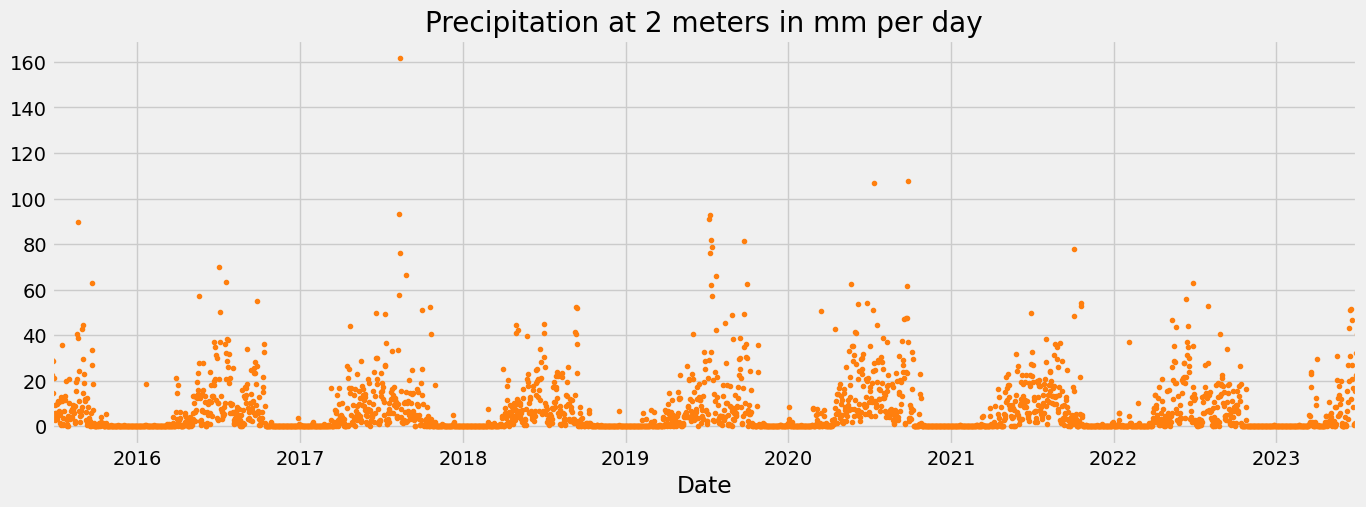

In [46]:
df_avg['PRECTOTCORR'].plot(
    style='.', figsize=(15, 5),
    color=color_pal[1],
    title="Precipitation at 2 meters in mm per day"
)

plt.show()

## Train & Test Split

Training: Before 2015-2021
Test: After 2022-2023

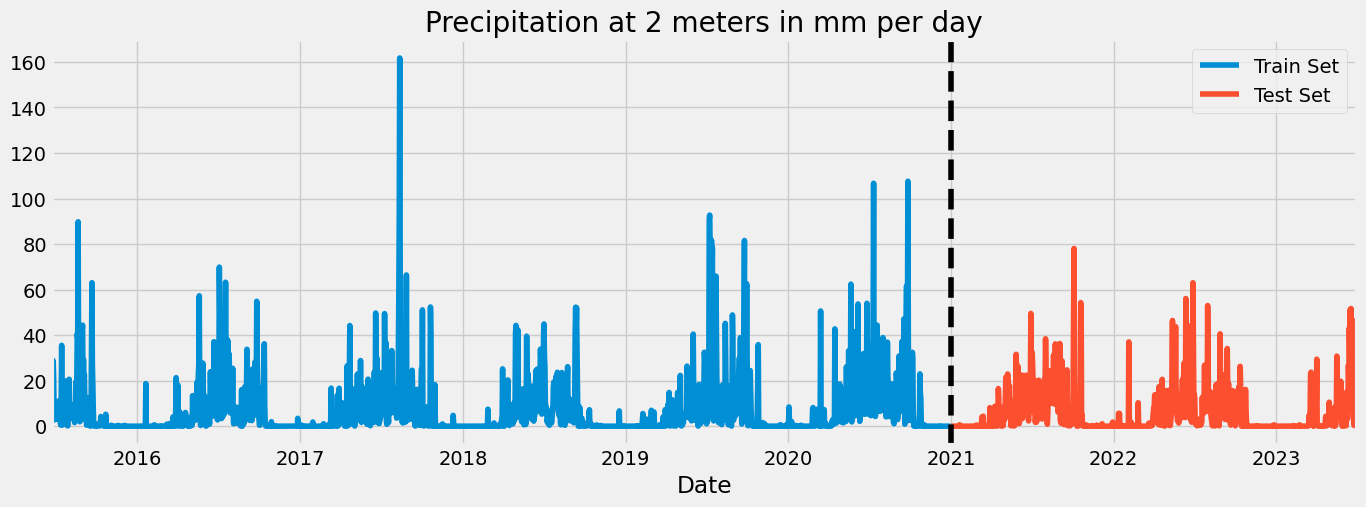

In [47]:
train = df_avg.loc[df_avg.index < '2021-01-01']
test = df_avg.loc[df_avg.index >= '2021-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train['PRECTOTCORR'].plot(ax=ax,
    label='Training Data Set',
    title="Precipitation at 2 meters in mm per day"
)

test['PRECTOTCORR'].plot(ax=ax,
    label='Test Data Set',
)

ax.axvline(x='2021-01-01', color='black', linestyle='--')
ax.legend(['Train Set', 'Test Set'])
plt.show()

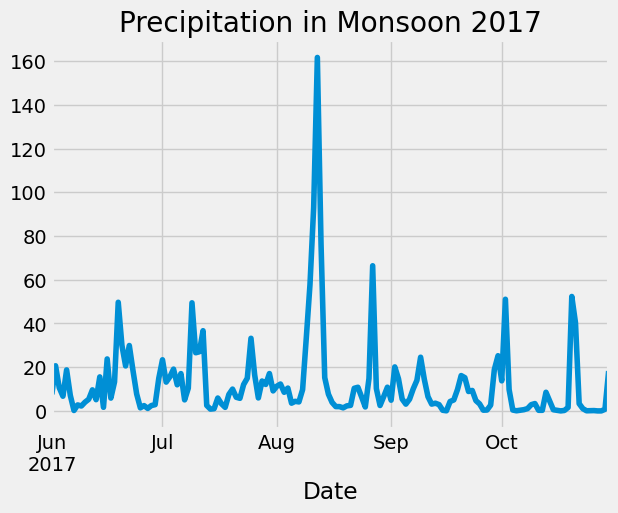

In [50]:
# Let's visualize a month of data in June (start of Monsoon)
train['PRECTOTCORR'].loc[(train.index >= '2017-06-01') &
 (train.index < '2017-10-31')].plot(title="Precipitation in Monsoon 2017")
plt.show()

## Feature Engineering


In [51]:
# Define the seasons based on DOY
def label_season(doy):
    if doy in range(335, 366) or doy in range(1, 60):
        return 'Dry Season'
    elif doy in range(60, 152):
        return 'Pre-Monsoon'
    elif doy in range(152, 244):
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

In [52]:
# Turn Wind Speed & Direction into Wind Vector
def calculate_wind_components(ws, wd):
    # Convert wind direction in degrees to radians
    wd_rad = wd * np.pi / 180

    # Compute x- and y-components of wind vector
    wx = ws * np.cos(wd_rad)
    wy = ws * np.sin(wd_rad)

    return wx, wy

In [70]:
def create_features(df, precip_windows=[1, 3, 5, 7]):
    df = df.copy()

    # Create time-related features
    df['Month'] = df.index.month
    df['Season'] = df['DOY'].apply(label_season)

    # One-Hot Encoding for the 'Season' column
    season_dummies = pd.get_dummies(df['Season'], prefix='Season')

    # Concatenate the new columns with the original DataFrame
    df = pd.concat([df, season_dummies], axis=1)

    # Capture the cyclical nature of day & month column
    days_in_year = 365
    months_in_year = 12

    # Sin and Cos transformation for DOY
    df['DOY_sin'] = np.sin(2 * np.pi * df['DOY'] / days_in_year)
    df['DOY_cos'] = np.cos(2 * np.pi * df['DOY'] / days_in_year)

    # Sin and Cos transformation for Month
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / months_in_year)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / months_in_year)

    # Calculate wind x and y components
    wx, wy = calculate_wind_components(df['WS2M'], df['WD2M'])
    df['ws2m_x'] = wx
    df['ws2m_y'] = wy

    wx, wy = calculate_wind_components(df['WS2M_MAX'], df['WD2M'])
    df['ws2m_max_x'] = wx
    df['ws2m_max_y'] = wy

    wx, wy = calculate_wind_components(df['WS2M_MIN'], df['WD2M'])
    df['ws2m_min_x'] = wx
    df['ws2m_min_y'] = wy

    wx, wy = calculate_wind_components(df['WS2M_RANGE'], df['WD2M'])
    df['ws2m_range_x'] = wx
    df['ws2m_range_y'] = wy

    # Let's accumulate
    for window_size in precip_windows:
      df[f'precip_mean_{window_size}'] = df['PRECTOTCORR'].rolling(window_size, min_periods=1).mean().shift(1)
      # Fill Na with 0
      df[f'precip_mean_{window_size}'] = df[f'precip_mean_{window_size}'].fillna(0)

    return df

In [71]:
window = [i for i in range(1, 8)]
train_final = create_features(train, precip_windows=window)
test_final = create_features(test, precip_windows=window)

In [72]:
corr_matrix = train_final.corr()
corr_matrix['PRECTOTCORR'].sort_values(ascending=False)

<ipython-input-72-b2c208dfabdd>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_final.corr()


PRECTOTCORR            1.000000
precip_mean_1          0.674627
precip_mean_2          0.616940
precip_mean_3          0.573596
precip_mean_4          0.537673
precip_mean_5          0.516907
precip_mean_6          0.498103
precip_mean_7          0.483210
QV2M                   0.480306
T2M_MIN                0.440678
GWETTOP                0.411486
RH2M                   0.408297
WS2M_MIN               0.388068
GWETROOT               0.383598
GWETPROF               0.383173
WS2M                   0.382725
Season_Monsoon         0.352371
T2M                    0.332982
WS2M_MAX               0.264017
ws2m_y                 0.230769
ws2m_min_y             0.226509
ws2m_max_y             0.221358
ws2m_range_y           0.212097
WS2M_RANGE             0.122316
T2M_MAX                0.118325
YEAR                   0.064505
DOY                    0.036662
Month                  0.035148
Season_Post-Monsoon   -0.032501
Season_Pre-Monsoon    -0.036788
DOY_sin               -0.110879
WD2M    

## Visualize Featute & Target

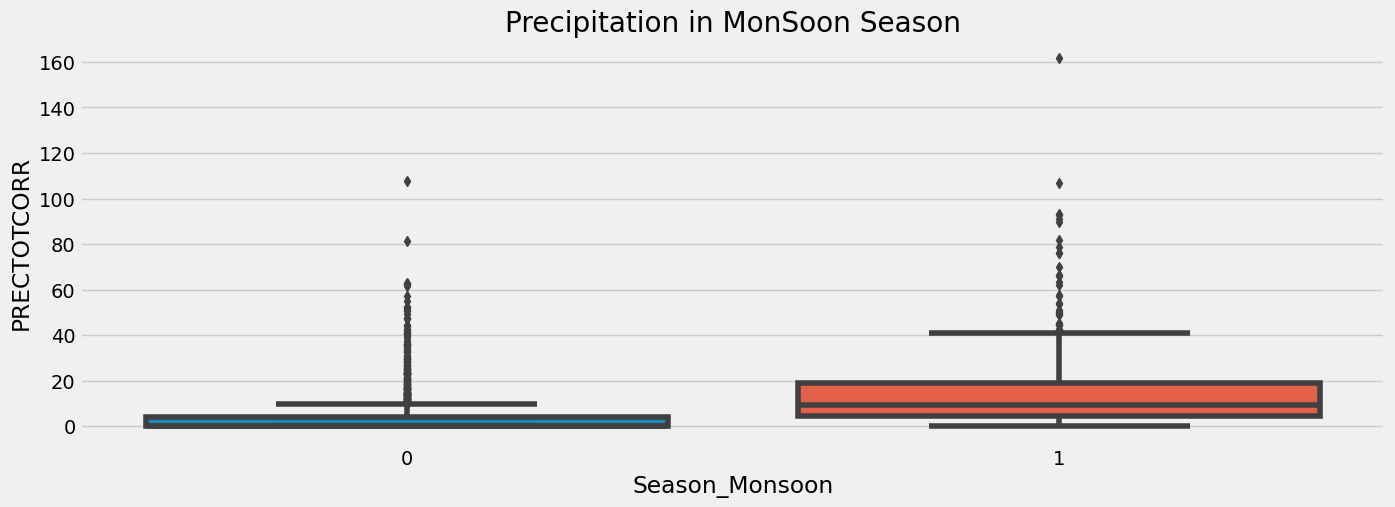

In [73]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=train_final, x='Season_Monsoon', y='PRECTOTCORR')
ax.set_title(f'Precipitation in MonSoon Season')
plt.show()

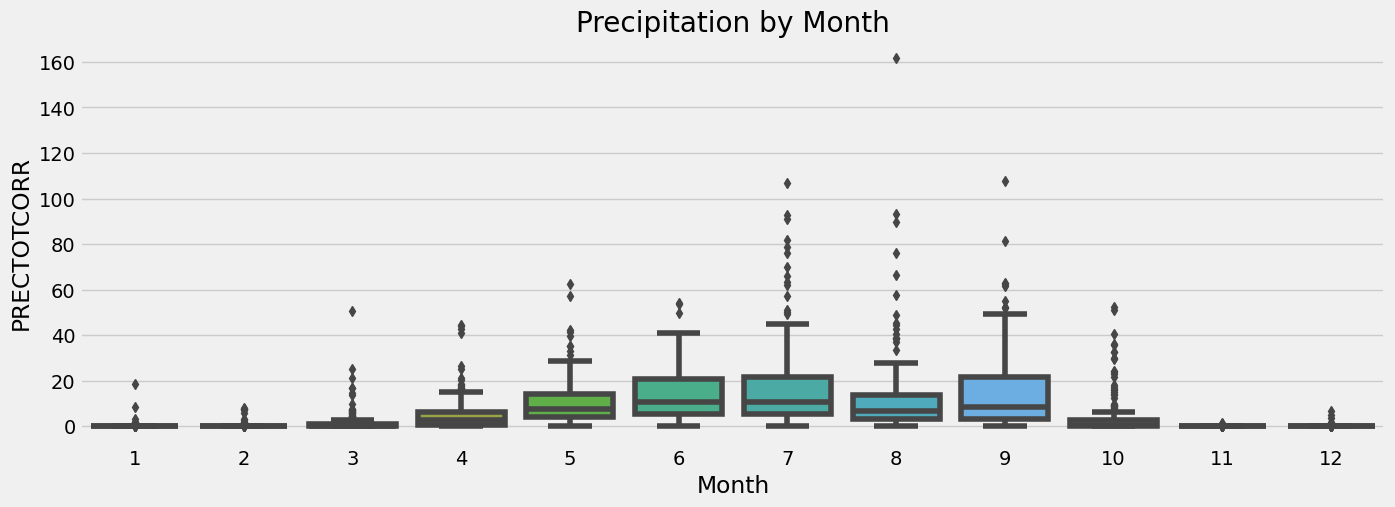

In [75]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=train_final, x='Month', y='PRECTOTCORR')
ax.set_title(f'Precipitation by Month')
plt.show()

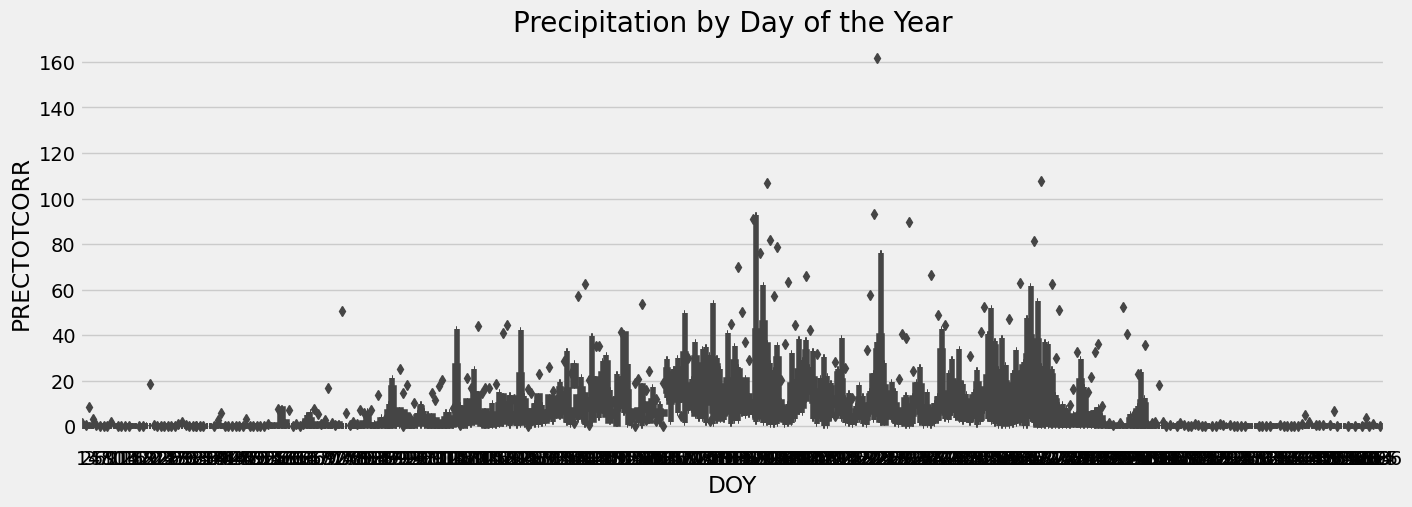

In [76]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=train_final, x='DOY', y='PRECTOTCORR')
ax.set_title(f'Precipitation by Day of the Year')
plt.show()

## Training the model

In [79]:
selected_features = ['T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
                     'WS2M', 'PS', 'WS2M_MAX', 'WS2M_MIN', 'GWETTOP',
                     'WS2M_RANGE', 'WD2M', 'GWETROOT', 'GWETPROF',
                     'Season_Dry Season', 'Season_Monsoon', 'Season_Post-Monsoon',
                     'Season_Pre-Monsoon', 'DOY_sin', 'DOY_cos', 'Month_sin',
                     'Month_cos','ws2m_x', 'ws2m_y', 'ws2m_max_x', 'ws2m_max_y',
                     'ws2m_min_x','ws2m_min_y', 'ws2m_range_x', 'ws2m_range_y',
                     'precip_mean_1','precip_mean_2', 'precip_mean_3',
                     'precip_mean_4', 'precip_mean_5','precip_mean_6',
                     'precip_mean_7']
label = ['PRECTOTCORR']

In [80]:
X_train, Y_train = train_final[selected_features], train_final[label]
X_test, Y_test = test_final[selected_features], test_final[label]

In [81]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2019, 38) (2019, 1)
(912, 38) (912, 1)


In [89]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': randint(100, 300),  # Smaller range for n_estimators
    'max_depth': randint(3, 7),  # Smaller range for max_depth
    'learning_rate': uniform(0.01, 0.2),  # Narrow range for learning_rate
    'subsample': uniform(0.6, 0.4),  # Range for subsample ratio
    'colsample_bytree': uniform(0.6, 0.4),  # Range for colsample_bytree
    'gamma': uniform(0, 1),  # Smaller range for gamma
    'min_child_weight': randint(1, 6)  # Smaller range for min_child_weight
}

# Define the model to tune
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Setup the randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Reduced number of iterations for initial search
    scoring='neg_mean_squared_error',  # Mean Squared Error as scoring
    n_jobs=-1,  # Use all cores
    cv=5,  # Increased number of folds in cross-validation for reliability
    verbose=1,  # Reduced verbosity for less output
    random_state=42  # For reproducibility
)

In [90]:
# Perform the randomized search over the parameter grid
random_search.fit(X_train, Y_train)

# Print the best parameters and lowest RMSE
best_parameters = random_search.best_params_
lowest_rmse = np.sqrt(-random_search.best_score_)

print(f"Best parameters found: {best_parameters}")
print(f"Lowest RMSE found: {lowest_rmse}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'colsample_bytree': 0.7292811728083021, 'gamma': 0.5187906217433661, 'learning_rate': 0.15060379177903557, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 285, 'subsample': 0.9849789179768444}
Lowest RMSE found: 6.8021116701597375


In [92]:
# Retrain with the best parameters on the full dataset
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    **best_parameters  # Unpack the best parameters
)
final_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7292811728083021, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.5187906217433661,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15060379177903557,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=285, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

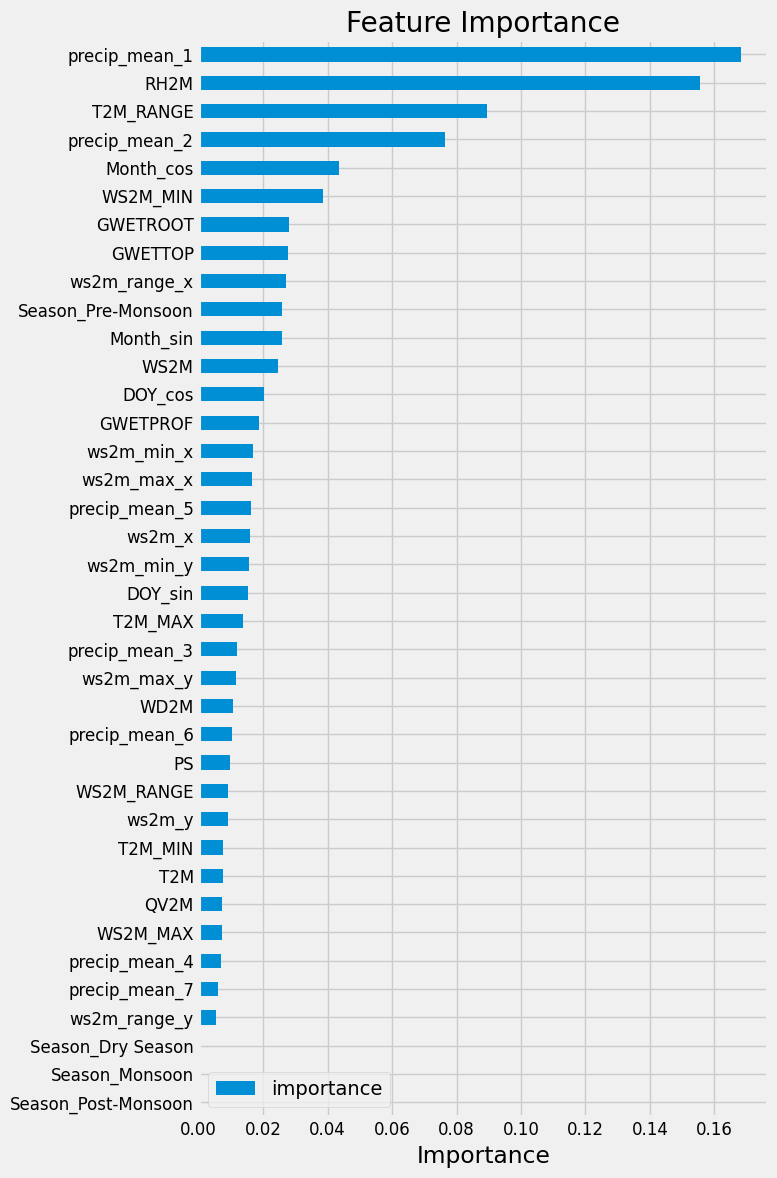

In [97]:
fi = pd.DataFrame(final_model.feature_importances_,
                  index=X_train.columns, columns=['importance'])

fi = fi.sort_values('importance')

fig, ax = plt.subplots(figsize=(8, 12))

fi.plot.barh(title="Feature Importance", ax=ax)

ax.set_yticklabels(fi.index, rotation=0)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylabel('')
ax.set_xlabel('Importance')

fig.tight_layout()

plt.show()

In [99]:
# Generate predictions on the test set
y_pred = final_model.predict(X_test)

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

# Calculate the MAE (Mean Absolute Error)
mae = mean_absolute_error(Y_test, y_pred)

# Calculate the R^2 score
r2 = r2_score(Y_test, y_pred)

# Print out the metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

RMSE: 5.299206319878928
MAE: 2.8470812081741834
R^2: 0.7297735366943954


In [101]:
X_test

,T2M,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,WS2M,PS,WS2M_MAX,WS2M_MIN,...,ws2m_min_y,ws2m_range_x,ws2m_range_y,precip_mean_1,precip_mean_2,precip_mean_3,precip_mean_4,precip_mean_5,precip_mean_6,precip_mean_7
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16.057692,13.520154,23.431231,9.911077,8.038000,72.088462,0.994462,101.040308,1.689846,0.424308,...,-0.323232,-0.817459,-0.961258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-02,16.361231,13.140154,23.304308,10.162615,7.730769,68.284769,0.909385,101.002615,1.492923,0.354308,...,-0.258436,-0.779951,-0.831641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-03,17.734462,11.954154,24.320462,12.368154,8.575846,69.278462,0.864769,100.853077,1.427846,0.268923,...,0.073957,-1.116012,0.319223,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-04,18.392769,11.967538,25.026615,13.059231,9.702308,74.966462,0.931692,100.911385,1.913231,0.345538,...,0.329703,-0.469610,1.497315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-05,19.024308,11.594923,25.427538,13.831538,10.116615,75.384308,0.812462,100.905692,1.532615,0.336154,...,-0.088808,-1.156326,-0.316742,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-27,28.389846,5.505077,31.424923,25.923385,21.339231,87.864462,3.344615,99.733692,4.727385,2.134769,...,1.833567,-1.326582,2.224832,1.378154,0.841615,0.885333,2.793962,5.552092,12.405256,14.476549
2023-06-28,28.103231,5.328769,31.127692,25.797692,21.290308,89.006769,2.926769,99.906462,4.266923,1.751692,...,1.336955,-1.626333,1.921124,15.409231,8.393692,5.697487,4.516308,5.317015,7.194949,12.834396
2023-06-29,27.964154,4.238308,30.336462,26.090615,21.471231,90.374000,2.673538,99.865692,3.858154,1.727077,...,0.520894,-2.028466,0.641675,21.554923,18.482077,12.780769,9.661846,7.924031,8.023333,9.246374


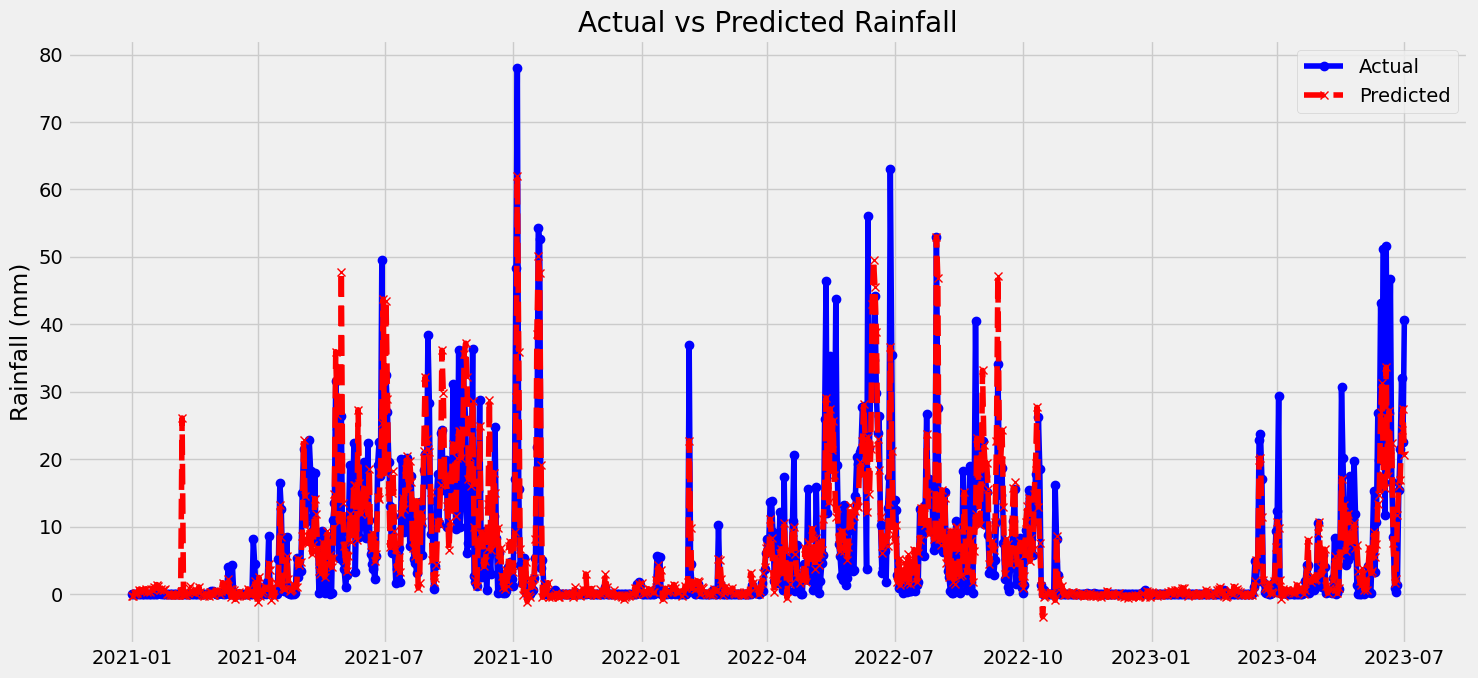

In [103]:
# Visualizing the prediction
plt.figure(figsize=(15, 7))
plt.plot(X_test.index, Y_test, label='Actual', color='blue', marker='o')  # Plot actual values
plt.plot(X_test.index, y_pred, label='Predicted', color='red', linestyle='--', marker='x')  # Plot predicted values
plt.title('Actual vs Predicted Rainfall')  # Set title
plt.ylabel('Rainfall (mm)')  # Set y-axis label
plt.legend()  # Show legend
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()  # Display the plot

## Summary of the results:

**Mean of PRECTOTCORR:** 6.6639 mm

**Standard Deviation of PRECTOTCORR:** 12.8017 mm

**RMSE:** 5.2992 mm (Below one standard deviation - Decent)

**MAE:** 2.8471 mm (Below mean & one standard deviation - so quite close to actual values)

NOTE: Given the skewed distributions, MAE is better predictor.


**R^2:** 0.7298 (72.98% decent predictor)


In [105]:
import joblib
cwd = '/content/drive/MyDrive/GIS Data Analysis'
joblib.dump(final_model, cwd + '/final_xgboost_model.joblib')

['/content/drive/MyDrive/GIS Data Analysis/final_xgboost_model.joblib']

In [109]:
# Saving test data for the prediction
# Concat all the columns in X_test and Y_test
combined_test = pd.concat([X_test, Y_test], axis=1)
combined_test

,T2M,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,WS2M,PS,WS2M_MAX,WS2M_MIN,...,ws2m_range_x,ws2m_range_y,precip_mean_1,precip_mean_2,precip_mean_3,precip_mean_4,precip_mean_5,precip_mean_6,precip_mean_7,PRECTOTCORR
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16.057692,13.520154,23.431231,9.911077,8.038000,72.088462,0.994462,101.040308,1.689846,0.424308,...,-0.817459,-0.961258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-02,16.361231,13.140154,23.304308,10.162615,7.730769,68.284769,0.909385,101.002615,1.492923,0.354308,...,-0.779951,-0.831641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-03,17.734462,11.954154,24.320462,12.368154,8.575846,69.278462,0.864769,100.853077,1.427846,0.268923,...,-1.116012,0.319223,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-04,18.392769,11.967538,25.026615,13.059231,9.702308,74.966462,0.931692,100.911385,1.913231,0.345538,...,-0.469610,1.497315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-05,19.024308,11.594923,25.427538,13.831538,10.116615,75.384308,0.812462,100.905692,1.532615,0.336154,...,-1.156326,-0.316742,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-27,28.389846,5.505077,31.424923,25.923385,21.339231,87.864462,3.344615,99.733692,4.727385,2.134769,...,-1.326582,2.224832,1.378154,0.841615,0.885333,2.793962,5.552092,12.405256,14.476549,15.409231
2023-06-28,28.103231,5.328769,31.127692,25.797692,21.290308,89.006769,2.926769,99.906462,4.266923,1.751692,...,-1.626333,1.921124,15.409231,8.393692,5.697487,4.516308,5.317015,7.194949,12.834396,21.554923
2023-06-29,27.964154,4.238308,30.336462,26.090615,21.471231,90.374000,2.673538,99.865692,3.858154,1.727077,...,-2.028466,0.641675,21.554923,18.482077,12.780769,9.661846,7.924031,8.023333,9.246374,32.101077


In [110]:
combined_test.to_csv(cwd + "/test_data.csv")